In [1]:
from input_preprocess import tokenizer
from lwm_model import lwm
import torch
import numpy as np

# 选择数据集
scenario_names = np.array([
    "city_18_denver", "city_15_indianapolis", "city_19_oklahoma",
    "city_12_fortworth", "city_11_santaclara", "city_7_sandiego"
])
scenario_idxs = np.array([0, 1, 2, 3, 4, 5])  
selected_scenario_names = scenario_names[scenario_idxs]

In [43]:
# 对数据进行标记
preprocessed_chs = tokenizer(
    selected_scenario_names=selected_scenario_names,  # Selects predefined DeepMIMOv3 scenarios_test. Set to None to load your own dataset.
    manual_data=None,  # If using a custom dataset, ensure it is a wireless channel dataset of size (N,32,32) based on the settings provided above.
    gen_raw=True  # Set gen_raw=False to apply masked channel modeling (MCM), as used in LWM pre-training. For inference, masking is unnecessary unless you want to evaluate LWM's ability to handle noisy inputs.
)


Basestation 3

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_18_denver/BS3_UE_0-6970.mat


Generating channels: 100%|██████████| 6970/6970 [00:00<00:00, 42575.26it/s]



Basestation 3

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_15_indianapolis/BS3_UE_0-6320.mat


Generating channels: 100%|██████████| 6320/6320 [00:00<00:00, 12501.21it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_19_oklahoma/BS1_UE_0-6150.mat


Generating channels: 100%|██████████| 6150/6150 [00:00<00:00, 10900.97it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_12_fortworth/BS1_UE_0-6192.mat


Generating channels: 100%|██████████| 6192/6192 [00:00<00:00, 25382.66it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_11_santaclara/BS1_UE_0-5358.mat


Generating channels: 100%|██████████| 5358/5358 [00:00<00:00, 14828.29it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_7_sandiego/BS1_UE_0-5893.mat


Processing items: 100%|██████████| 14840/14840 [00:00<00:00, 42186.67it/s]


In [44]:
# 加载模型
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
print(f"Loading the LWM model on {device}...")
model = lwm.from_pretrained(device=device)

Loading the LWM model on cpu...
Model loaded successfully from /Users/dianhongyang/Desktop/毕业设计/LWM_Model/LWM/model_weights.pth to cpu


In [45]:
# 进行推理
from inference import lwm_inference, create_raw_dataset
input_types = ['cls_emb', 'channel_emb', 'raw']
selected_input_type = input_types[0]  # Change the index to select LWM CLS embeddings, LWM channel embeddings, or the original input channels.

if selected_input_type in ['cls_emb', 'channel_emb']:
    dataset = lwm_inference(preprocessed_chs, selected_input_type, model, device)
else:
    dataset = create_raw_dataset(preprocessed_chs, device)

LWM loss: 0.0193


In [46]:
dataset.shape

torch.Size([14840, 64])

In [47]:
from input_preprocess import create_labels
import numpy as np
tasks = ['LoS/NLoS Classification', 'Beam Prediction']
task = tasks[0] # Choose 0 for LoS/NLoS labels or 1 for beam prediction labels.
labels = create_labels(task, scenario_names, n_beams=64) # For beam prediction, n_beams specifies the number of beams in the codebook. If you're generating labels for LoS/NLoS classification, you can leave this value unchanged as it doesn't impact the label generation.


Basestation 3

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_18_denver/BS3_UE_0-6970.mat


Generating channels: 100%|██████████| 6970/6970 [00:00<00:00, 39932.44it/s]



Basestation 3

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_15_indianapolis/BS3_UE_0-6320.mat


Generating channels: 100%|██████████| 6320/6320 [00:00<00:00, 12602.82it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_19_oklahoma/BS1_UE_0-6150.mat


Generating channels: 100%|██████████| 6150/6150 [00:00<00:00, 9962.51it/s] 



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_12_fortworth/BS1_UE_0-6192.mat


Generating channels: 100%|██████████| 6192/6192 [00:00<00:00, 20467.45it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_11_santaclara/BS1_UE_0-5358.mat


Generating channels: 100%|██████████| 5358/5358 [00:00<00:00, 15039.41it/s]



Basestation 1

UE-BS Channels
/Users/dianhongyang/Desktop/毕业设计/LWM_MODEL/LWM/scenarios/city_7_sandiego/BS1_UE_0-5893.mat


Generating channels: 100%|██████████| 5893/5893 [00:00<00:00, 13415.32it/s]


In [48]:
labels = torch.tensor(labels)

In [11]:
dataset.shape

torch.Size([14840, 64])

In [49]:
# 划分数据集 设置50%训练集 50%验证集
from sklearn.model_selection import train_test_split    
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.5, random_state=42)

In [73]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import numpy as np
# 使用 TensorDataset 将数据和标签封装成 PyTorch Dataset 对象
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)


# 划分训练集和验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

batch_size = 64
# 提取训练数据以进行归一化
scaler = StandardScaler()

# 获取训练集、验证集和测试集的数据和标签
train_x = torch.stack([train_data[i][0] for i in range(len(train_data))])  # 提取训练集数据
train_y = torch.tensor([train_data[i][1] for i in range(len(train_data))])  # 提取训练集标签

val_x = torch.stack([val_data[i][0] for i in range(len(val_data))])  # 提取验证集数据
val_y = torch.tensor([val_data[i][1] for i in range(len(val_data))])  # 提取验证集标签

test_x = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])  # 提取测试集数据
test_y = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))])  # 提取测试集标签

# 在训练集上拟合 StandardScaler，并对训练集进行变换
scaler.fit(train_x.numpy())
train_x = torch.tensor(scaler.transform(train_x.numpy()), dtype=torch.float32)

# 对验证集和测试集进行变换（使用训练集拟合的 StandardScaler）
val_x = torch.tensor(scaler.transform(val_x.numpy()), dtype=torch.float32)
test_x = torch.tensor(scaler.transform(test_x.numpy()), dtype=torch.float32)

# 将归一化后的数据重新封装成 TensorDataset
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

# 使用 DataLoader 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 训练集
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # 验证集
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # 测试集


In [81]:
# 创建下游任务模型 并放入mps加速
from torch.nn import Sequential, ReLU, Linear, Softmax, CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Sequential, ReLU, Linear, Softmax, Dropout

model = Sequential(
        Linear(64, 1024),
        ReLU(),
        Dropout(0.2),
        Linear(1024, 520),
        ReLU(),
        Dropout(0.2),
        Linear(520, 64),
        ReLU(),
        Dropout(0.2),
        Linear(64, 2),   # 输入 D_MODEL 维度，输出 2 类
        Softmax(dim=1)   # 归一化
)

print(f'model:\n{model}')


model:
Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=520, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=520, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=2, bias=True)
  (10): Softmax(dim=1)
)


In [77]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: mps


In [78]:
# 损失函数和优化器
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)  # 每 20 轮学习率减小
# TensorBoard 日志记录
writer = SummaryWriter("Log/loss_CLS_5_5")

# 训练模型
epochs = 400
for epoch in range(epochs):
    model.train()  # 切换到训练模式
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        # 将数据移动到设备
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    writer.add_scalar("train_loss", train_loss, epoch)

    model.eval()  # 切换到评估模式
    val_corrent = 0
    evl_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # 将数据移动到设备
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            evl_loss += loss
            val_corrent+= (torch.argmax(outputs, dim=1) == batch_y).sum().item()
            
    writer.add_scalar("evl_loss", evl_loss, epoch)
    writer.add_scalar("evl_accurancy", val_corrent/len(val_data), epoch)
    scheduler.step()  # 调整学习率
writer.close()

Test Accuracy: 0.9570
Confusion Matrix:
 [[2705  158]
 [ 161 4396]]


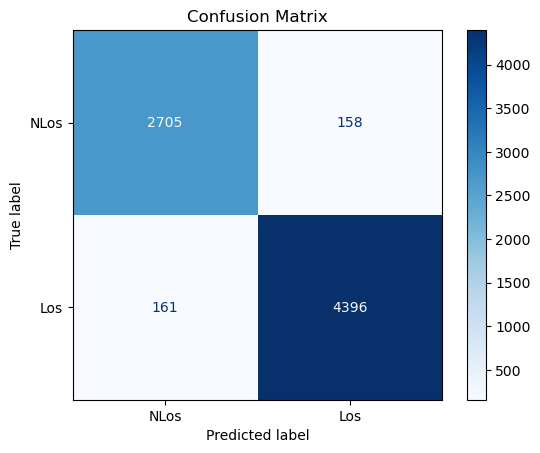

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 评估阶段
model.eval()
test_correct = 0
# 存储预测值和真实标签
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        # 将数据移动到设备
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1)

        # 记录预测和真实值
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        test_correct += (torch.argmax(outputs, dim=1) == batch_y).sum().item()


print(f"Test Accuracy: {test_correct / len(y_test):.4f}")


conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)

# 混淆矩阵
class_names = ["NLos", "Los"] 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
